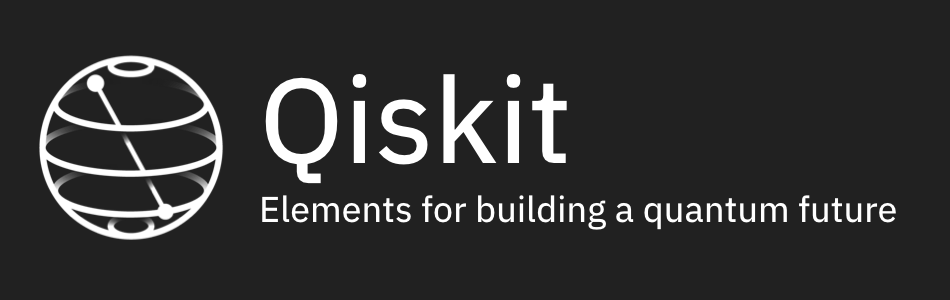

# _*Qiskit Aqua: Solving linear systems of equations with the HHL algorithm*_

***
### Contributors
David Bucher<sup>[1]</sup>, Jan Mueggenburg<sup>[1]</sup>, Gawel Kus<sup>[1]</sup>, Isabel Haide<sup>[1]</sup>, Shubha Deutschle<sup>[1]</sup>, Harry Barowski<sup>[1]</sup>, Dominik Steenken<sup>[1]</sup>, and Albert Frisch<sup>[1]</sup>
### Affiliation
- <sup>[1]</sup>IBMQ

The HHL algorithm (after the author’s surnames Harrow-Hassidim-Lloyd) [1] is a quantum algorithm to solve systems of linear equations $A \vec{x} = \vec{b}$. To perform this calculation quantum mechanically, we need in general 4 main steps requiring three qubit registers:
<ol>
<li>First, we have to express the vector $\vec{b}$ as a quantum state $|b\rangle$ on a quantum register.</li>
<li>Now, we have to decompose $\vec{b}$ into a superposition of eigenvectors of $A$ remembering on the linear combination of the vector $\vec{b}$. We achieve this using the Quantum Phase Estimation algorithm (Quantum Phase Estimation (QPE)). Since the matrix is hereby diagonalized wherefore $A$ is easily invertible.</li>
<li>The inversion of the eigenvector base of $A$ is achieved by rotating an ancillary qubit by an angle $\arcsin \left( \frac{C}{\lambda _{\text{i}}} \right)$ around the y-axis where $\lambda_{\text{i}}$ are the eigenvalues of $A$. Now, we obtain the state $A^{-1}|b\rangle = |x \rangle$.</li>
<li>We need to uncompute the register storing the eigenvalues using the inverse QPE. We measure the ancillary qubit whereby the measurement of 1 indicates that the matrix inversion was successful. The inverse QPE leaves the system in a state proportional to the solution vector $|x\rangle$. In many cases one is not interested in the single vector elements of $|x\rangle$ but only on certain properties. These are accessible by applying a problem-specific operator $M$ to the state $|x\rangle$. Another use-case of the HHL algorithm is the implementation in a larger quantum program.</li>
</ol>
Currently only hermitian matrices with a dimension of $2^n$ are supported.

Take into account that in the general case, the entries of $\vec{x}$ can not be efficiently read out because we would need to know all coefficients describing the quantum state.
In the following examples, we ignore this constraint and show for our small linear system as a proof of principle that $\vec{x}$ is calculated correctly.

References:
- A. W. Harrow, A. Hassidim, and S. Lloyd, Phys. Rev. Lett. 103, 150502 (2009), e-print arXiv 0811.3171
- S. Barz, I. Kassal, M. Ringbauer, Y. Ole Lipp, B. Dakić, A. Aspuru-Guzik, and P. Walther, Sci Rep. 4: 6115 (2014), e-print arXiv 1302.1210

In [1]:
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms import HHL, ExactLSsolver
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.qfts import Standard as StandardQFTS
from qiskit.aqua.components.iqfts import Standard as StandardIQFTS
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.initial_states import Custom
import numpy as np

In [2]:
def create_eigs(matrix, num_ancillae, negative_evals):
    ne_qfts = [None, None]
    if negative_evals:
        num_ancillae += 1
        ne_qfts = [StandardQFTS(num_ancillae - 1), StandardIQFTS(num_ancillae - 1)]

    return EigsQPE(MatrixOperator(matrix=matrix),
                   StandardIQFTS(num_ancillae),
                   num_time_slices=50,
                   num_ancillae=num_ancillae,
                   expansion_mode='suzuki',
                   expansion_order=2,
                   evo_time=None,
                   negative_evals=negative_evals,
                   ne_qfts=ne_qfts)

def fidelity(hhl, ref):
    solution_hhl_normed = hhl / np.linalg.norm(hhl)
    solution_ref_normed = ref / np.linalg.norm(ref)
    fidelity = state_fidelity(solution_hhl_normed, solution_ref_normed)
    print("fidelity %f" % fidelity)

## 2x2 diagonal matrix

First, we show an example for running the HHL algorithm with Qiskit Aqua on a diagonal matrix as input
$$
A=
\begin{bmatrix}
1 & 0 \\
0 & 2
\end{bmatrix}$$ with the vector $$\vec{b}= \left( \begin{array}{c}1 \\ 4  \end{array} \right)$$
The `result` dictionary contains several return values. The HHL solution for $\vec{x}$ is accessible by the key `'solution'`. For comparison, also the classical solution of the linear system of equations is calculated using standard linear algebra functions in numpy. The fidelity between the HHL solution and the classical solution is also given in the output. Furthermore, the probability is shown with which HHL was running successfully, i.e. the HHL ancillary qubit has been measured to be $|1\rangle$.

In [3]:
matrix = [[1, 0], [0, 2]]
vector = [1, 4]

In [4]:
orig_size = len(vector)
matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(matrix, vector)

# Initialize eigenvalue finding module
eigs = create_eigs(matrix, 3, False)
num_q, num_a = eigs.get_register_sizes()

# Initialize initial state module
init_state = Custom(num_q, state_vector=vector)

# Initialize reciprocal rotation module
reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time)

algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs,
           init_state, reci, num_q, num_a, orig_size)
result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))

print("solution ", np.round(result['solution'], 5))

result_ref = ExactLSsolver(matrix, vector).run()
print("classical solution ", np.round(result_ref['solution'], 5))

print("probability %f" % result['probability_result'])
fidelity(result['solution'], result_ref['solution'])

solution  [1.05859-0.j 1.99245-0.j]
classical solution  [1. 2.]
probability 0.024630
fidelity 0.999389


The probabilty that HHL runs successfully depends on the constant $C$ (see step 3. in the introduction). In the HHL algorithm, $C$ can be given as the parameter `scale` $\in [0,1]$. In the above example `scale` is not defined and the HHL algorithm initializes `scale` to the smallest possible eigenvalue before execution. Alternatively, we can set `scale` to 0.5 and see how the results are influenced thereby.

In [5]:
orig_size = len(vector)
matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(matrix, vector)

# Initialize eigenvalue finding module
eigs = create_eigs(matrix, 3, False)
num_q, num_a = eigs.get_register_sizes()

# Initialize initial state module
init_state = Custom(num_q, state_vector=vector)

# Initialize reciprocal rotation module
reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time, scale=0.5)

algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs,
           init_state, reci, num_q, num_a, orig_size)
result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))

print("solution ", np.round(result['solution'], 5))

result_ref = ExactLSsolver(matrix, vector).run()
print("classical solution ", np.round(result_ref['solution'], 5))

print("probability %f" % result['probability_result'])
fidelity(result['solution'], result_ref['solution'])

solution  [0.84664-0.j 2.01762-0.j]
classical solution  [1. 2.]
probability 0.361437
fidelity 0.995605


If you want to know how many qubits are required (circuit width) or how large the maximum number of gates applied to a single qubit (circuit depth) is, you can print it out by

In [6]:
print("circuit_width", result['circuit_info']['width'])
print("circuit_depth", result['circuit_info']['depth'])

circuit_width 7
circuit_depth 129


## 2x2 non-diagonal matrix

Here we show an example for running the HHL algorithm with Qiskit Aqua on a non-diagonal matrix as input
$$
A=
\begin{bmatrix}
1 & 3 \\
3 & 2
\end{bmatrix}$$ with the vector $$\vec{b}= \left( \begin{array}{c}1 \\ 1  \end{array} \right)$$


In [7]:
matrix = [[1, 3], [3, 2]]
vector = [1, 1]

In [8]:
orig_size = len(vector)
matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(matrix, vector)

# Initialize eigenvalue finding module
eigs = create_eigs(matrix, 3, True)
num_q, num_a = eigs.get_register_sizes()

# Initialize initial state module
init_state = Custom(num_q, state_vector=vector)

# Initialize reciprocal rotation module
reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time)

algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs,
           init_state, reci, num_q, num_a, orig_size)
result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
print("solution ", np.round(result['solution'], 5))

result_ref = ExactLSsolver(matrix, vector).run()
print("classical solution ", np.round(result_ref['solution'], 5))

print("probability %f" % result['probability_result'])
fidelity(result['solution'], result_ref['solution'])

solution  [0.13449+0.j 0.29238+0.j]
classical solution  [0.14286 0.28571]
probability 0.022362
fidelity 0.998942


Compared to the first example, the circuit depth is increased approximately by a factor of 6

In [9]:
print("circuit_width", result['circuit_info']['width'])
print("circuit_depth", result['circuit_info']['depth'])

circuit_width 8
circuit_depth 221


## 8x8 non-diagonal matrix

For simplicity, we show a HHL execution of a linear systom of equations defined by the following 8x8 dimensional matrix
$$
A=
\begin{bmatrix}
4 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 3 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 8 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 5 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 2 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 5
\end{bmatrix}$$ and the vector $$\vec{b}= \left( \begin{array}{c}1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \end{array} \right)$$

In [10]:
matrix = [[4, 0, 0, 0, 0, 0, 0, 1],
          [0, 3, 0, 0, 0, 0, 0, 0],
          [0, 0, 8, 0, 0, 0, 0, 0],
          [0, 0, 0, 5, 0, 0, 0, 0],
          [0, 0, 0, 0, 2, 1, 0, 0],
          [0, 0, 0, 0, 1, 1, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 0],
          [1, 0, 0, 0, 0, 0, 0, 5]]
vector = [1, 0, 0, 0, 0, 0, 0, 1]

In [11]:
orig_size = len(vector)
matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(matrix, vector)

# Initialize eigenvalue finding module
eigs = create_eigs(matrix, 3, False)
num_q, num_a = eigs.get_register_sizes()

# Initialize initial state module
init_state = Custom(num_q, state_vector=vector)

# Initialize reciprocal rotation module
reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time)

algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs,
           init_state, reci, num_q, num_a, orig_size)
result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
print("solution ", np.round(result['solution'], 5))

result_ref = ExactLSsolver(matrix, vector).run()
print("classical solution ", np.round(result_ref['solution'], 5))

print("probability %f" % result['probability_result'])
fidelity(result['solution'], result_ref['solution'])

solution  [ 0.21492-0.j  0.     -0.j  0.     +0.j -0.     +0.j  0.     +0.j
 -0.     +0.j -0.     +0.j  0.1542 -0.j]
classical solution  [0.21053 0.      0.      0.      0.      0.      0.      0.15789]
probability 0.085481
fidelity 0.999553


Considering the circuit depth and circuit width

In [12]:
print("circuit_width", result['circuit_info']['width'])
print("circuit_depth", result['circuit_info']['depth'])

circuit_width 9
circuit_depth 156


## 4x4 randomly-generated matrix

Now, we show the application of HHL on a randomly-generated 4x4 matrix. We use the function `random_hermitian` to generate a random hermitian matrix and initialize the random seed to achieve reproducibility of the HHL run. Since the matrix can have negative eigenvalues, the parameters need to be modifies to `negative_evals=True` in `"eigs"` and `reciprocal`, respectively. We choose $$\vec{b}= \left( \begin{array}{c}1 \\ 2 \\ 3 \\ 1 \end{array} \right)$$

In [13]:
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms.single_sample import HHL
from qiskit.aqua.utils import random_hermitian

In this example, we create an instance of the `HHL` class and run the algorithm with an input that is created programatically. To get the same pseudo-random matrix for every run, we set the random seed by using `np.random.seed(1)`.

In [ ]:
# set the random seed to get the same pseudo-random matrix for every run
np.random.seed(1)
matrix = random_hermitian(4)
vector = [1, 2, 3, 1]

print("random matrix:")
m = np.array(matrix)
print(np.round(m, 3))

orig_size = len(vector)
matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(matrix, vector)

# Initialize eigenvalue finding module
eigs = create_eigs(matrix, 6, True)
num_q, num_a = eigs.get_register_sizes()

# Initialize initial state module
init_state = Custom(num_q, state_vector=vector)

# Initialize reciprocal rotation module
reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time)

algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs,
           init_state, reci, num_q, num_a, orig_size)
result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))

print("solution ", np.round(result['solution'], 5))

result_ref = ExactLSsolver(matrix, vector).run()
print("classical solution ", np.round(result_ref['solution'], 5))

print("probability %f" % result['probability_result'])
fidelity(result['solution'], result_ref['solution'])

random matrix:
[[ 0.284-0.j    -0.257-0.051j -0.124+0.033j  0.038+0.023j]
 [-0.257+0.051j  0.404+0.j     0.067-0.079j  0.054+0.055j]
 [-0.124-0.033j  0.067+0.079j  0.282-0.j     0.043+0.004j]
 [ 0.038-0.023j  0.054-0.055j  0.043-0.004j  0.206-0.j   ]]


The circuit width and depth are

In [ ]:
print("circuit_width", result['circuit_info']['width'])
print("circuit_depth", result['circuit_info']['depth'])

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright